Package importing

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

Read a data

In [25]:
train_path=r"C:\Programs Practice\Python\Machine learning Tasks (codesoft)\genre_predictor\Genre Classification Dataset\train_data.txt"
train_data=pd.read_csv(train_path,sep=":::",names=["TITLE","GENRE","DESCRIPTION"],engine="python",encoding="utf-8")

In [26]:
train_data

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [28]:
train_data.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [29]:
train_data.isnull().sum()

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [30]:
test_path=r"C:\Programs Practice\Python\Machine learning Tasks (codesoft)\genre_predictor\Genre Classification Dataset\test_data.txt"
test_data=pd.read_csv(test_path,sep=":::",names=["TITLE","DESCRIPTION"],engine="python")

In [31]:
test_data

,TITLE,DESCRIPTION
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...
54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54200 entries, 1 to 54200
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  object
 1   DESCRIPTION  54200 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


EDA

C:\Users\acer\AppData\Local\Temp\ipykernel_56268\2492482807.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='GENRE', order=train_data['GENRE'].value_counts().index, palette='viridis')
C:\Users\acer\AppData\Local\Temp\ipykernel_56268\2492482807.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='viridis')


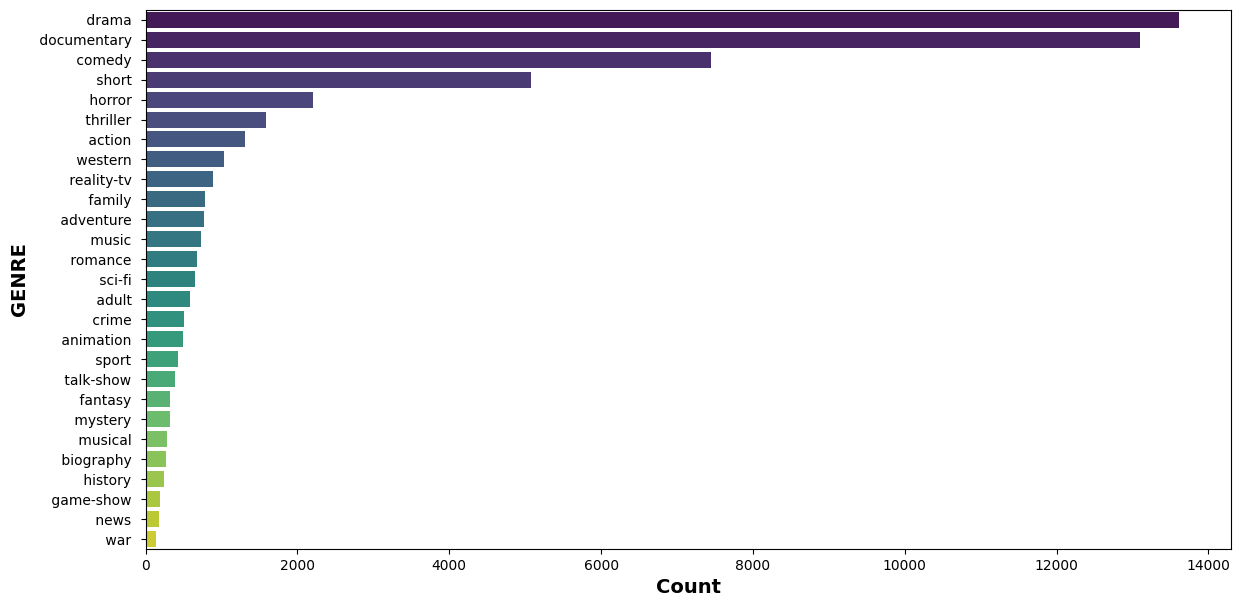

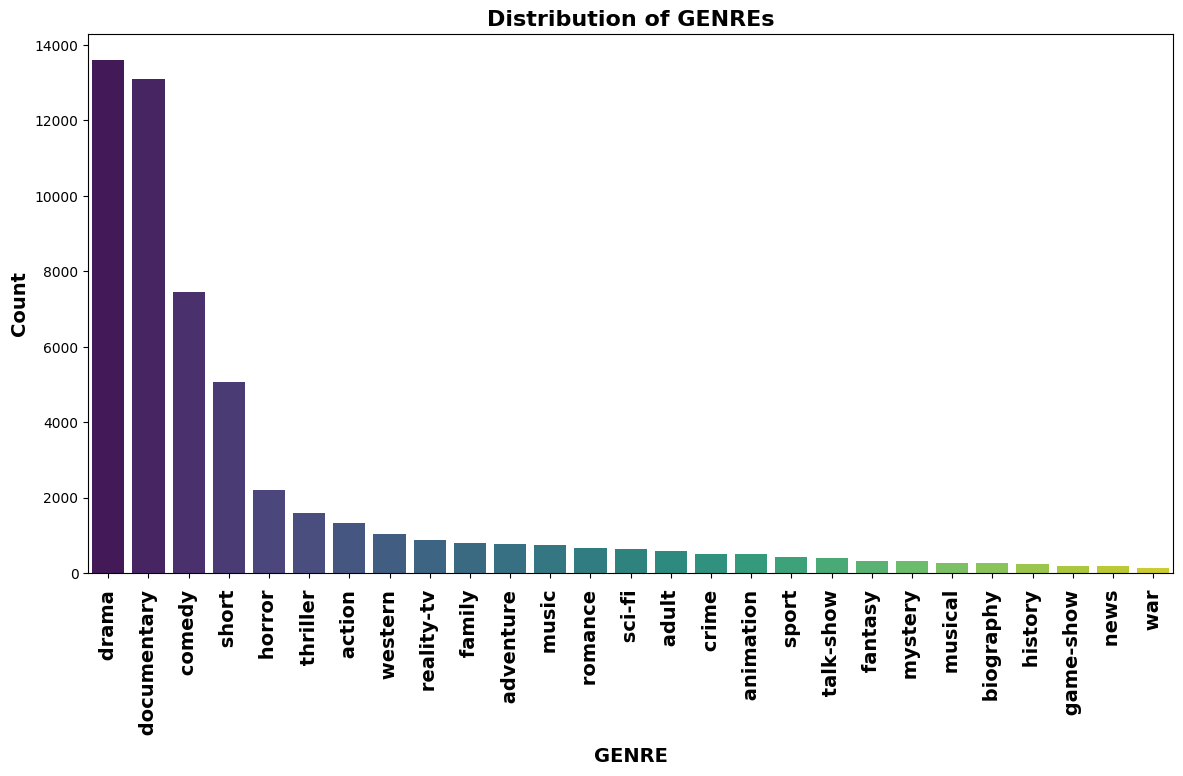

In [34]:
# Plot the distribution of GENREs in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='GENRE', order=train_data['GENRE'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('GENRE', fontsize=14, fontweight='bold')

# Plot the distribution of GENREs using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['GENRE'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('GENRE', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of GENREs', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

Data Preprocessing

In [35]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'DESCRIPTION' column in the training and test data
train_data['Text_cleaning'] = train_data['DESCRIPTION'].apply(clean_text)
test_data['Text_cleaning'] = test_data['DESCRIPTION'].apply(clean_text)

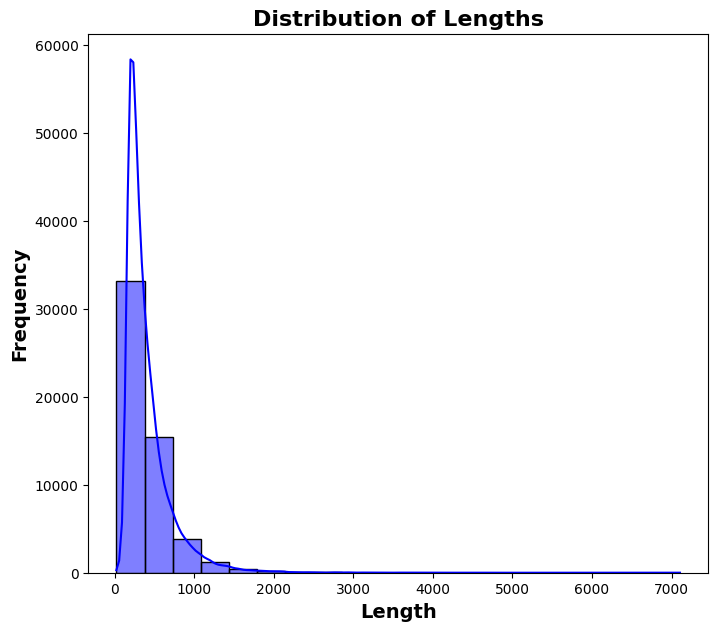

In [36]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

Using TF-IDF to vectorize the data

In [37]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [39]:
# Split the data into training and validation sets
X = X_train
y = train_data['GENRE']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [40]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [41]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(test_data)

                                  TITLE  \
1                 Edgar's Lunch (1998)    
2             La guerra de papá (1977)    
3          Off the Beaten Track (2010)    
4               Meu Amigo Hindu (2015)    
5                    Er nu zhai (1955)    
...                                 ...   
54196   "Tales of Light & Dark" (2013)    
54197      Der letzte Mohikaner (1965)    
54198              Oliver Twink (2007)    
54199                Slipstream (1973)    
54200        Curitiba Zero Grau (2010)    

                                             DESCRIPTION  \
1       L.R. Brane loves his life - his car, his apar...   
2       Spain, March 1964: Quico is a very naughty ch...   
3       One year in the life of Albin and his family ...   
4       His father has died, he hasn't spoken with hi...   
5       Before he was known internationally as a mart...   
...                                                  ...   
54196   Covering multiple genres, Tales of Light & Da...   
541